In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import math
import random
from pyampute.ampute import MultivariateAmputation

In [2]:
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#### Positional Encoder

In [4]:
class PositionalEncoding(nn.Module):
    """
    Fixed positional encoding for features (columns) in the transformer model.
    """
    def __init__(self, d_model, max_features=1000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_features, d_model)
        position = torch.arange(0, max_features, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x, column_indices):
        """
        Args:
            x: Input tensor [batch_size, num_features, d_model]
            column_indices: Tensor with column indices [num_features]
        """
        # Add positional encoding based on column indices
        x = x + self.pe[column_indices].unsqueeze(0)
        return self.dropout(x)

#### Transformer model

In [5]:
class TabularTransformer(nn.Module):
    """
    Transformer model for tabular data with improved architecture.
    """
    def __init__(self, 
                 num_features, 
                 d_model=64, 
                 nhead=4, 
                 num_layers=2, 
                 dim_feedforward=256, 
                 dropout=0.1, 
                 activation='gelu'):
        super(TabularTransformer, self).__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        
        # Feature value embedding
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model)
        )
        
        # Column embedding (learnable)
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        # Add positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        # Layer normalization before transformer
        self.norm = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True  # Pre-norm architecture for better training stability
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Output layers with skip connection design
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def _generate_attention_mask(self, mask):
        """Generate attention mask for transformer"""
        if mask is None:
            return None
        # Convert binary mask to attention mask (1 = attend, 0 = ignore)
        attn_mask = (1 - mask).bool()
        return attn_mask
                
    def forward(self, x, column_indices, mask=None):
        """
        Forward pass of the transformer model.
        
        Args:
            x: Input tensor [batch_size, num_features]
            column_indices: Tensor of column indices [num_features]
            mask: Optional mask for missing values [batch_size, num_features]
            
        Returns:
            Tensor of predicted values [batch_size, num_features]
        """
        batch_size = x.size(0)
        
        # Reshape to [batch_size, num_features, 1] for embedding
        x = x.unsqueeze(-1)
        
        # Embed feature values
        x_embedded = self.value_embedding(x)
        
        # Add column embeddings
        col_embed = self.column_embedding(column_indices).unsqueeze(0).expand(batch_size, -1, -1)
        x_embedded = x_embedded + col_embed
        
        # Apply positional encoding
        x_embedded = self.pos_encoder(x_embedded, column_indices)
        
        # Apply layer normalization
        x_embedded = self.norm(x_embedded)
        
        # Generate attention mask if needed
        attn_mask = self._generate_attention_mask(mask) if mask is not None else None
        
        # Pass through transformer encoder
        x_encoded = self.transformer_encoder(x_embedded, src_key_padding_mask=attn_mask)
        
        # Project to output
        output = self.output_projection(x_encoded).squeeze(-1)
        
        return output

In [6]:
def create_missing_mask(data, missing_fraction=0.2, mechanism="MCAR"):
    """
    Create a mask for missing values using different mechanisms.
    
    Args:
        data (torch.Tensor): Input data tensor
        missing_fraction (float): Fraction of values to mask
        mechanism (str): One of "MCAR", "MAR", or "MNAR"
        
    Returns:
        torch.Tensor: Binary mask (1 = missing, 0 = present)
    """
    try:
        # MCAR implementation - completely random
        if mechanism == "MCAR":
            mask = torch.rand(data.shape, device=data.device) < missing_fraction
            return mask.int()
        
        # Simulated MAR (missing at random) implementation
        # In MAR, missingness depends on observed values but not on missing values
        elif mechanism == "MAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # Number of features
            num_features = data.shape[1]
            
            # For each column, make missingness depend on values in other columns
            for col_idx in range(num_features):
                # Choose a different column as predictor (wrapping around if needed)
                predictor_col = (col_idx + 1) % num_features
                
                # Get predictor values
                predictor_values = data[:, predictor_col]
                
                # Normalize predictor values to [0, 1] range
                if predictor_values.max() > predictor_values.min():
                    normalized_values = (predictor_values - predictor_values.min()) / (predictor_values.max() - predictor_values.min())
                else:
                    normalized_values = torch.zeros_like(predictor_values)
                
                # Higher predictor values = higher chance of missingness
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.5 + torch.rand(data.shape[0], device=data.device) * 0.5
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Simulated MNAR (missing not at random) implementation
        # In MNAR, missingness depends on the missing values themselves
        elif mechanism == "MNAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # For each column, make missingness depend on its own values
            for col_idx in range(data.shape[1]):
                # Get column values
                col_values = data[:, col_idx]
                
                # Normalize values to [0, 1] range
                if col_values.max() > col_values.min():
                    normalized_values = (col_values - col_values.min()) / (col_values.max() - col_values.min())
                else:
                    normalized_values = torch.zeros_like(col_values)
                
                # For MNAR, higher values have higher probability of being missing
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.7 + torch.rand(data.shape[0], device=data.device) * 0.3
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Default to MCAR if unknown mechanism
        else:
            print(f"Unknown missing data mechanism: {mechanism}. Defaulting to MCAR.")
            return create_missing_mask(data, missing_fraction, "MCAR")
            
    except Exception as e:
        print(f"Error creating {mechanism} mask: {e}")
        # Fall back to MCAR if there's an error
        return create_missing_mask(data, missing_fraction, "MCAR")


In [7]:
def load_and_prepare_data(data_path, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Load and prepare data for model training.
    
    Args:
        data_path (str): Path to the CSV file
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed train, validation, test tensors, scaler, and column indices
    """
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path, index_col=0)
    
    # Check for missing values
    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: Dataset contains {missing_count} missing values. These will be handled in preprocessing.")
        # Simple imputation for missing values
        df = df.fillna(df.mean())
    
    # Convert to numpy for preprocessing
    data = df.to_numpy()
    
    # Split data into train and test
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio,
        random_state=random_state
    )
    
    # Normalize data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32).to(device)
    val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32).to(device)
    test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices
    column_indices = torch.arange(train_tensor.shape[1]).to(device)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of training samples: {train_tensor.shape[0]}")
    print(f"Number of validation samples: {val_tensor.shape[0]}")
    print(f"Number of test samples: {test_tensor.shape[0]}")
    print(f"Number of features: {train_tensor.shape[1]}")
    
    return train_tensor, val_tensor, test_tensor, scaler, column_indices

In [8]:
def compute_loss(predictions, ground_truth, mask):
    """
    Compute mean squared error loss on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        torch.Tensor: Mean squared error loss
    """
    mse_loss = nn.MSELoss(reduction='none')
    loss = mse_loss(predictions, ground_truth)
    # Normalize by number of masked positions
    masked_loss = (loss * mask).sum() / (mask.sum() + 1e-8)
    return masked_loss

In [9]:
def compute_rmse(predictions, ground_truth, mask):
    """
    Compute Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: RMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [10]:
def compute_nrmse(predictions, ground_truth, mask):
    """
    Compute Normalized Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: NRMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

In [11]:
def train_epoch(model, dataloader, optimizer, missing_fraction, mechanisms=None, scheduler=None):
    """
    Train for one epoch.
    
    Args:
        model (nn.Module): Model to train
        dataloader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        scheduler (LRScheduler, optional): Learning rate scheduler
        
    Returns:
        dict: Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        x = batch[0].to(device)
        
        # Randomly select a mechanism for this batch
        mechanism = random.choice(mechanisms)
        
        # Create a mask for missing values
        mask = create_missing_mask(x, missing_fraction, mechanism)
        
        # Create input with missing values set to 0
        x_masked = x.clone()
        x_masked[mask == 1] = 0
        
        # Forward pass
        optimizer.zero_grad()
        column_indices = torch.arange(x.shape[1], device=device)
        predictions = model(x_masked, column_indices, mask)
        
        # Compute loss
        loss = compute_loss(predictions, x, mask)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return {"loss": avg_loss}

In [12]:
def validate(model, dataloader, missing_fraction, mechanisms=None):
    """
    Validate the model.
    
    Args:
        model (nn.Module): Model to validate
        dataloader (DataLoader): Validation data loader
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        
    Returns:
        dict: Dictionary with validation metrics
    """
    model.eval()
    total_loss = 0
    total_rmse = 0
    total_nrmse = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    mechanism_metrics = {m: {"loss": 0, "rmse": 0, "nrmse": 0, "count": 0} for m in mechanisms}
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            
            for mechanism in mechanisms:
                # Create a mask for missing values
                mask = create_missing_mask(x, missing_fraction, mechanism)
                
                # Create input with missing values set to 0
                x_masked = x.clone()
                x_masked[mask == 1] = 0
                
                # Forward pass
                column_indices = torch.arange(x.shape[1], device=device)
                predictions = model(x_masked, column_indices, mask)
                
                # Compute metrics
                loss = compute_loss(predictions, x, mask)
                rmse = compute_rmse(predictions, x, mask)
                nrmse = compute_nrmse(predictions, x, mask)
                
                # Update mechanism-specific metrics
                mechanism_metrics[mechanism]["loss"] += loss.item()
                mechanism_metrics[mechanism]["rmse"] += rmse
                mechanism_metrics[mechanism]["nrmse"] += nrmse
                mechanism_metrics[mechanism]["count"] += 1
                
                # Update overall metrics
                total_loss += loss.item()
                total_rmse += rmse
                total_nrmse += nrmse
    
    # Calculate averages
    num_evaluations = len(dataloader) * len(mechanisms)
    avg_loss = total_loss / num_evaluations
    avg_rmse = total_rmse / num_evaluations
    avg_nrmse = total_nrmse / num_evaluations
    
    # Calculate mechanism-specific averages
    for m in mechanisms:
        if mechanism_metrics[m]["count"] > 0:
            mechanism_metrics[m]["loss"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["rmse"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["nrmse"] /= mechanism_metrics[m]["count"]
    
    return {
        "loss": avg_loss,
        "rmse": avg_rmse,
        "nrmse": avg_nrmse,
        "mechanisms": mechanism_metrics
    }

In [13]:
def train_model(train_data, val_data, column_indices, config):
    """
    Train the model.
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model
    num_features = train_data.shape[1]
    model = TabularTransformer(
        num_features=num_features,
        d_model=config["d_model"],
        nhead=config["num_heads"],
        num_layers=config["num_layers"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
        activation=config["activation"]
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=total_steps,
        eta_min=config["learning_rate"] * 0.01
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_nrmse": [],
        "val_mcar_nrmse": [],
        "val_mar_nrmse": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_nrmse"].append(val_metrics["nrmse"])
        history["val_mcar_nrmse"].append(val_metrics["mechanisms"]["MCAR"]["nrmse"])
        history["val_mar_nrmse"].append(val_metrics["mechanisms"]["MAR"]["nrmse"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val NRMSE: {val_metrics['nrmse']:.4f}")
        print(f"Val MCAR NRMSE: {val_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"Val MAR NRMSE: {val_metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history


In [14]:
def plot_training_history(history, save_path=None):
    """
    Plot training history.
    
    Args:
        history (dict): Training history
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(20, 12))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot NRMSE
    plt.subplot(2, 2, 2)
    plt.plot(history["val_nrmse"], label="Overall NRMSE")
    plt.plot(history["val_mcar_nrmse"], label="MCAR NRMSE")
    plt.plot(history["val_mar_nrmse"], label="MAR NRMSE")
    plt.plot(history["val_mnar_nrmse"], label="MNAR NRMSE")
    plt.title("NRMSE by Mechanism")
    plt.xlabel("Epoch")
    plt.ylabel("NRMSE")
    plt.legend()
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.tight_layout()
    plt.show()

In [15]:
def save_model(model, scaler, config, save_dir="models"):
    """
    Save model and related objects.
    
    Args:
        model (nn.Module): Trained model
        scaler (StandardScaler): Data scaler
        config (dict): Model configuration
        save_dir (str): Directory to save model
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "tabular_transformer.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, model_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    import pickle
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

Loading data from ./data/physionet_39_features_only.csv
Dataset shape: (2008, 38)
Number of training samples: 1405
Number of validation samples: 201
Number of test samples: 402
Number of features: 38
Starting model training...


c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Epoch 1/100


Training: 100%|██████████| 22/22 [00:02<00:00,  9.58it/s, loss=4.44] 


Train Loss: 4.6000
Val Loss: nan
Val NRMSE: 0.1020
Val MCAR NRMSE: 0.0799
Val MAR NRMSE: 0.0998
Val MNAR NRMSE: 0.1263
No improvement for 1 epochs

Epoch 2/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.22it/s, loss=1.68] 


Train Loss: 2.4666
Val Loss: nan
Val NRMSE: 0.1160
Val MCAR NRMSE: 0.0848
Val MAR NRMSE: 0.1091
Val MNAR NRMSE: 0.1540
No improvement for 2 epochs

Epoch 3/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.25it/s, loss=1.45]


Train Loss: 1.7047
Val Loss: 1.9184
Val NRMSE: 0.0984
Val MCAR NRMSE: 0.0896
Val MAR NRMSE: 0.0870
Val MNAR NRMSE: 0.1184
New best validation loss: 1.9184

Epoch 4/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.53it/s, loss=1.67] 


Train Loss: 1.7534
Val Loss: 1.9340
Val NRMSE: 0.0992
Val MCAR NRMSE: 0.1002
Val MAR NRMSE: 0.0854
Val MNAR NRMSE: 0.1119
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.58it/s, loss=0.784]


Train Loss: 2.2236
Val Loss: nan
Val NRMSE: 0.0987
Val MCAR NRMSE: 0.0885
Val MAR NRMSE: 0.0888
Val MNAR NRMSE: 0.1189
No improvement for 2 epochs

Epoch 6/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.62it/s, loss=1.48] 


Train Loss: 1.9382
Val Loss: 1.9751
Val NRMSE: 0.0975
Val MCAR NRMSE: 0.0894
Val MAR NRMSE: 0.0849
Val MNAR NRMSE: 0.1182
No improvement for 3 epochs

Epoch 7/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.87it/s, loss=3.5]  


Train Loss: 2.0776
Val Loss: 1.7129
Val NRMSE: 0.0960
Val MCAR NRMSE: 0.0855
Val MAR NRMSE: 0.0849
Val MNAR NRMSE: 0.1176
New best validation loss: 1.7129

Epoch 8/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.30it/s, loss=1.05] 


Train Loss: 2.2578
Val Loss: nan
Val NRMSE: 0.0971
Val MCAR NRMSE: 0.0742
Val MAR NRMSE: 0.0920
Val MNAR NRMSE: 0.1251
No improvement for 1 epochs

Epoch 9/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.41it/s, loss=0.732]


Train Loss: 1.8461
Val Loss: nan
Val NRMSE: 0.0996
Val MCAR NRMSE: 0.0752
Val MAR NRMSE: 0.0940
Val MNAR NRMSE: 0.1294
No improvement for 2 epochs

Epoch 10/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s, loss=1.46] 


Train Loss: 1.9840
Val Loss: nan
Val NRMSE: 0.1044
Val MCAR NRMSE: 0.1127
Val MAR NRMSE: 0.0933
Val MNAR NRMSE: 0.1073
No improvement for 3 epochs

Epoch 11/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.21it/s, loss=1.17] 


Train Loss: 1.8750
Val Loss: 1.9774
Val NRMSE: 0.1003
Val MCAR NRMSE: 0.0789
Val MAR NRMSE: 0.0907
Val MNAR NRMSE: 0.1314
No improvement for 4 epochs

Epoch 12/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.50it/s, loss=1.66] 


Train Loss: 1.8427
Val Loss: nan
Val NRMSE: 0.0966
Val MCAR NRMSE: 0.0837
Val MAR NRMSE: 0.0869
Val MNAR NRMSE: 0.1191
No improvement for 5 epochs

Epoch 13/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.12it/s, loss=1.39] 


Train Loss: 1.6560
Val Loss: nan
Val NRMSE: 0.0990
Val MCAR NRMSE: 0.0968
Val MAR NRMSE: 0.0845
Val MNAR NRMSE: 0.1158
No improvement for 6 epochs

Epoch 14/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.92it/s, loss=1.15] 


Train Loss: 1.7897
Val Loss: nan
Val NRMSE: 0.0997
Val MCAR NRMSE: 0.0865
Val MAR NRMSE: 0.0924
Val MNAR NRMSE: 0.1202
No improvement for 7 epochs

Epoch 15/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.75it/s, loss=3.21] 


Train Loss: 1.7717
Val Loss: nan
Val NRMSE: 0.0995
Val MCAR NRMSE: 0.0968
Val MAR NRMSE: 0.0900
Val MNAR NRMSE: 0.1117
No improvement for 8 epochs

Epoch 16/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.98it/s, loss=1.08] 


Train Loss: 1.9008
Val Loss: nan
Val NRMSE: 0.0952
Val MCAR NRMSE: 0.0887
Val MAR NRMSE: 0.0764
Val MNAR NRMSE: 0.1205
No improvement for 9 epochs

Epoch 17/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.50it/s, loss=1.19]


Train Loss: 2.5190
Val Loss: nan
Val NRMSE: 0.1094
Val MCAR NRMSE: 0.1167
Val MAR NRMSE: 0.1053
Val MNAR NRMSE: 0.1062
No improvement for 10 epochs

Epoch 18/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.51it/s, loss=0.971]


Train Loss: 1.8193
Val Loss: nan
Val NRMSE: 0.0936
Val MCAR NRMSE: 0.0740
Val MAR NRMSE: 0.0797
Val MNAR NRMSE: 0.1272
No improvement for 11 epochs

Epoch 19/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.22it/s, loss=1.5]  


Train Loss: 1.9003
Val Loss: nan
Val NRMSE: 0.1027
Val MCAR NRMSE: 0.1066
Val MAR NRMSE: 0.0935
Val MNAR NRMSE: 0.1080
No improvement for 12 epochs

Epoch 20/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.26it/s, loss=1.76] 


Train Loss: 1.6043
Val Loss: nan
Val NRMSE: 0.0989
Val MCAR NRMSE: 0.0869
Val MAR NRMSE: 0.0927
Val MNAR NRMSE: 0.1170
No improvement for 13 epochs

Epoch 21/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.04it/s, loss=2.91] 


Train Loss: 1.9844
Val Loss: nan
Val NRMSE: 0.1007
Val MCAR NRMSE: 0.0951
Val MAR NRMSE: 0.0908
Val MNAR NRMSE: 0.1162
No improvement for 14 epochs

Epoch 22/100


Training: 100%|██████████| 22/22 [00:02<00:00, 10.80it/s, loss=4.11] 


Train Loss: 2.1775
Val Loss: nan
Val NRMSE: 0.1011
Val MCAR NRMSE: 0.0904
Val MAR NRMSE: 0.0956
Val MNAR NRMSE: 0.1174
No improvement for 15 epochs
Early stopping after 22 epochs


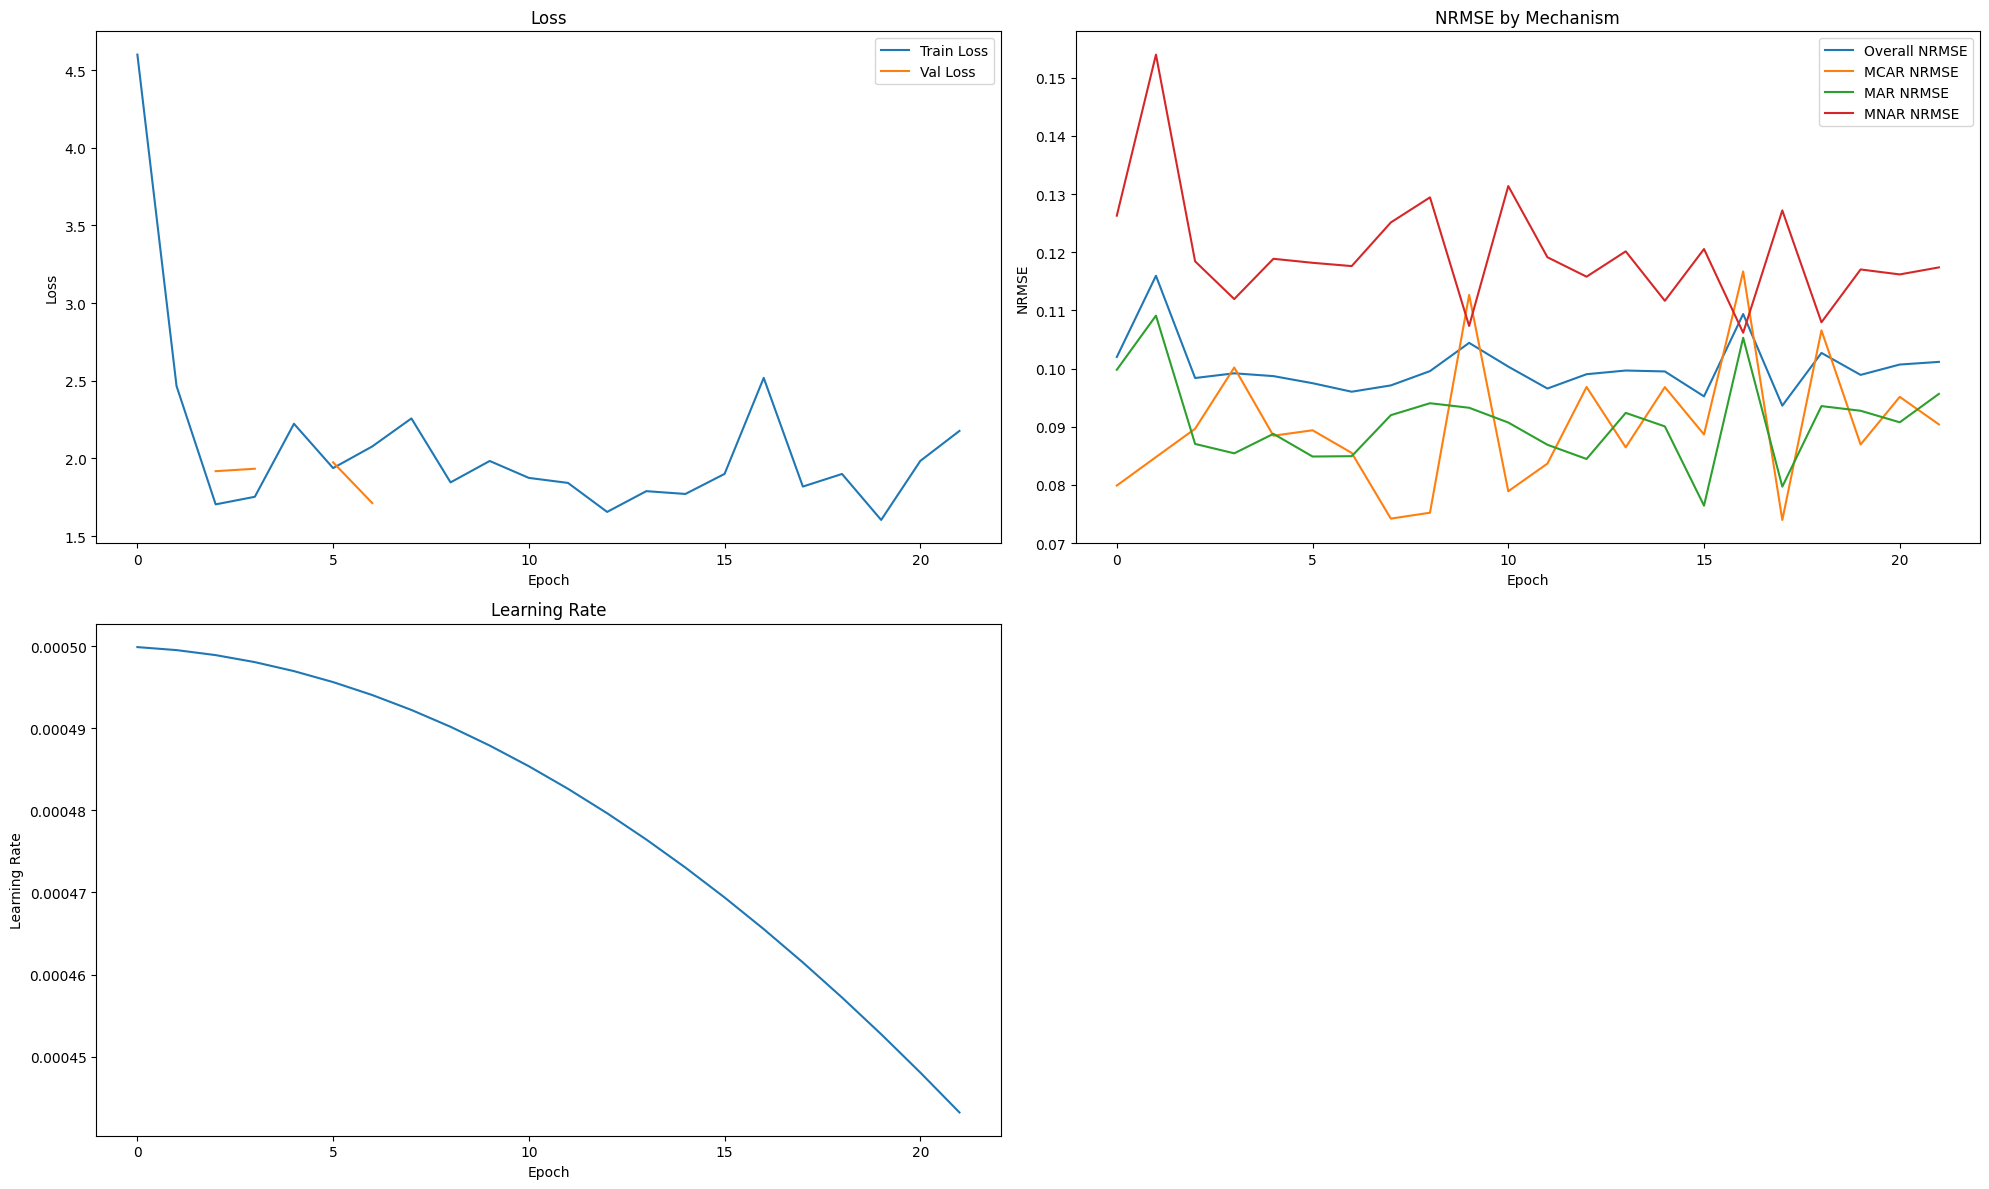

Model saved to models\2025-03-30_18-05-03_model\tabular_transformer.pth
Scaler saved to models\2025-03-30_18-05-03_model\scaler.pkl
Training complete! Model saved in: models\2025-03-30_18-05-03_model


In [16]:
from datetime import datetime

# Main execution code
if __name__ == "__main__":
    # Configuration
    config = {
        # Data parameters
        "data_path": "./data/physionet_39_features_only.csv",
        "test_size": 0.2,
        "val_size": 0.1,
        
        # Model parameters
        "d_model": 512,          # 4x original value
        "num_heads": 16,         # Doubled from 8 (512 ÷ 16 = 32)
        "num_layers": 6,         # Doubled from 3
        "dim_feedforward": 2048,
        "dropout": 0.2,
        "activation": "gelu",
        
        # Training parameters
        "batch_size": 64,
        "learning_rate": 0.0005,
        "weight_decay": 0.01,
        "num_epochs": 100,
        "patience": 15,
        "missing_fraction": 0.3,
        
        # Save parameters
        "save_dir": "models"
    }
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(config["save_dir"], f"{current_time}_model")
    os.makedirs(save_dir, exist_ok=True)
        
    # Load and prepare data
    train_data, val_data, test_data, scaler, column_indices = load_and_prepare_data(
        config["data_path"],
        config["test_size"],
        config["val_size"]
    )
    
    # Train model
    model, history = train_model(train_data, val_data, column_indices, config)

    # Plot training history
    plot_training_history(history, os.path.join(save_dir, "training_history.png"))

    # Save model
    save_model(model, scaler, config, save_dir)

    print(f"Training complete! Model saved in: {save_dir}")